In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from hepunits import constants as c
from hepunits import units as u
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

u.dalton = 1.660539068e-27 * u.kg

In [405]:
# Setup parameters
target_width = 0.25 * u.mm
beam_energy = 1 * u.GeV
beam_current = 100e-6 * u.A
beam_diameter = 100 * u.mm
beam_charge = -1

# Aluminium
#
# Not good, because of 26Al
# target_material = {'27Al': 1.0} # Mole-fractions
# target_density = 2.7 * u.g / u.cm3
# beam_time = 60 * u.s
# decay_time = 3 * 60 * u.s

# Phosphorus
#
# Could work, but... phosphorus :/
#target_material = {"31P": 1.0}  # Mole-fractions
#target_density = 2.7 * u.g / u.cm3  # Black phosphorus
#beam_time = 2 * u.h
#decay_time = 4 * u.h

# Scandium
#
# Could work, but 45Ca mean b- energy is only 77 keV
target_material = {'45Sc': 1.0} # Mole-fractions
target_density = 3 * u.g / u.cm3
beam_time = 10 * u.d
decay_time = 45 * u.d

# Silver
#
# Doesn't work because of 106Cd
# target_material = {"107Ag": 0.52, "109Ag": 0.48}  # Mole-fractions
# target_density = 10.5 * u.g / u.cm3
# beam_time = 100 * u.s
# decay_time = 14 * u.h

# Indium
#
# Not good, since Indium 115 itself is radioactive
# target_material = {"113In": 0.043, "115In": 0.957}  # Mole-fractions
# target_density = 7.3 * u.g / u.cm3
# beam_time = 0.1 * u.h
# decay_time = 100 * u.h

# Antimony
#
# Not good, because of 121Te
# target_material = {"123Sb": 0.428, "121Sb": 0.572}  # Mole-fractions
# target_density = 8.9 * u.g / u.cm3
# beam_time = 1 * u.d
# decay_time = 200 * u.d

# Praseodymium
#
# Noot good, because of 139Ce
# target_material = {'141Pr': 1.0} # Mole-fractions
# target_density = 6.8 * u.g / u.cm3
# beam_time = 1 * u.d
# decay_time = 45 * u.d
# beam_current = 0.01e-6 * u.A

# Tantalum
#
# Noot good, because of 179Ta
# target_material = {'181Ta': 1.0} # Mole-fractions
# target_density = 16.7 * u.g / u.cm3
# beam_time = 10 * u.d
# decay_time = 45 * u.d
# beam_current = 0.01e-6 * u.A

beam_time_step = beam_time / 20
decay_time_step = decay_time / 200

In [406]:
# Get decay rates and daughters of isotopes

import re
import urllib.request
from functools import lru_cache


@lru_cache(maxsize=None)
def lc_pd_dataframe(**kwargs):
    url = "https://nds.iaea.org/relnsd/v1/data?"
    url += "&".join((f"{k}={v}" for k, v in kwargs.items()))
    req = urllib.request.Request(url)
    req.add_header(
        "User-Agent",
        "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0",
    )
    return pd.read_csv(urllib.request.urlopen(req))

In [407]:
all_ground_states = lc_pd_dataframe(fields="ground_states", nuclides="all")


@lru_cache(maxsize=None)
def get_decay_rates(nuclide):
    A, symbol = re.fullmatch("(\d+)(\S+)", nuclide).groups()
    A = int(A)
    ground_state = all_ground_states.query(f"n + z == {A} & symbol == '{symbol}'").iloc[
        0
    ]
    half_life = ground_state[f"half_life_sec"] * u.s
    if np.isnan(half_life):
        half_life = 1e-99 * u.s
    Z = ground_state["z"]
    N = ground_state["n"]
    daughters = {}
    total_ratio = 0
    for i_d in range(1, 4):
        decay_mode = ground_state[f"decay_{i_d}"]
        if not isinstance(decay_mode, str):
            break
        decay_ratio = ground_state[f"decay_{i_d}_%"]
        if np.isnan(decay_ratio):
            decay_ratio = 1e-99

        if "B-" in decay_mode:
            d_n = N - 1
            d_z = Z + 1
        elif "B+" in decay_mode or "EC" in decay_mode:
            d_n = N + 1
            d_z = Z - 1
        elif "A" in decay_mode:
            d_n = N - 2
            d_z = Z - 2
        elif "N" in decay_mode:
            d_n = N - 1
            d_z = Z
        elif "P" in decay_mode:
            d_n = N
            d_z = Z - 1
        else:
            break

        try:
            d_symbol = all_ground_states.query(f"n == {d_n} & z == {d_z}").iloc[0][
                "symbol"
            ]
        except IndexError:
            continue

        decay = {"d_symbol": d_symbol, "d_n": d_n, "d_z": d_z}

        dsym = decay["d_symbol"]
        dA = decay["d_n"] + decay["d_z"]
        daughters[f"{dA}{dsym}"] = decay_ratio
        total_ratio += decay_ratio

    for k in daughters:
        # Normalise branching ratios
        daughters[k] /= total_ratio
        # Multiply with decay rate
        daughters[k] *= np.log(2) / half_life

    return daughters

In [408]:
# Get activation cross sections for isotopes


def get_cross_sections(nuclide):
    A, symbol = re.fullmatch("(\d+)(\S+)", nuclide).groups()
    A = int(A)
    ground_state = all_ground_states.query(f"n + z == {A} & symbol == '{symbol}'").iloc[
        0
    ]
    half_life = ground_state[f"half_life_sec"] * u.s
    if np.isnan(half_life):
        half_life = 1e-99 * u.s
    Z = ground_state["z"]
    N = ground_state["n"]

    # Very basic for now
    daughters = {}
    try:
        p_symbol = all_ground_states.query(f"n == {N} & z == {Z-1}").iloc[0]["symbol"]
        daughters[f"{A-1}{p_symbol}"] = Z * 4 * u.fm2  # Kick out a proton
    except IndexError:
        pass

    try:
        pn_symbol = all_ground_states.query(
            f"n == {N-beam_charge} & z == {Z+beam_charge}"
        ).iloc[0]["symbol"]
        daughters[f"{A}{pn_symbol}"] = (
            70e-42 * u.cm2
        )  # Turn a proton into a neutron or vice versa depending on beam charge
    except IndexError:
        pass

    try:
        n_symbol = all_ground_states.query(f"n == {N-1} & z == {Z}").iloc[0]["symbol"]
        daughters[f"{A-1}{symbol}"] = 100e-3 * u.barn  # Kick out a neutron
    except IndexError:
        pass

    return daughters

In [409]:
# Initial number of isotopes
beam_area = c.pi * (beam_diameter / 2) ** 2
target_volume = beam_area * target_width
target_mass = target_volume * target_density
target_nucleons = target_mass / u.dalton

start_numbers = {}
for nuc, rel in target_material.items():
    start_numbers[nuc] = target_nucleons * rel

start_numbers

{'45Sc': 3.547333717703812e+24}

In [410]:
get_cross_sections("31P")

{'30Si': 6e-23, '31Si': 7e-39, '30P': 1e-23}

In [411]:
# Simulate the irradiation
beamsteps = int(beam_time / beam_time_step)
decaysteps = int(decay_time / decay_time_step)
current_numbers = start_numbers
numbers = []


def add_numbers(time, current):
    for nuc, num in current.items():
        dec = get_decay_rates(nuc)
        rate = sum(dec.values())
        numbers.append(
            {"time": time, "nuclide": nuc, "number": num, "decay_rate": rate}
        )


add_numbers(0, current_numbers)


def simulate(current_numbers, start_time, time_step, num_steps, beam_on):
    time = start_time
    for _ in trange(num_steps):
        time += time_step
        next_numbers = dict(current_numbers)
        for nuc, current in current_numbers.items():
            for daughter, rate in get_decay_rates(nuc).items():
                decay_fraction = 1 - np.exp(-rate * time_step)
                decay_number = current * decay_fraction
                decay_number = min(decay_number, next_numbers[nuc])
                next_numbers[nuc] -= decay_number
                next_numbers[daughter] = next_numbers.get(daughter, 0) + decay_number

            if beam_on:
                for daughter, xsec in get_cross_sections(nuc).items():
                    rate = (
                        xsec
                        * (current / beam_area)
                        * (beam_current / c.eplus)
                        / current
                    )
                    interaction_fraction = rate * time_step
                    if interaction_fraction > 1e-6:
                        interaction_fraction = 1 - np.exp(-rate * time_step)
                    interaction_number = interaction_fraction * current
                    interaction_number = min(interaction_number, next_numbers[nuc])
                    next_numbers[nuc] -= interaction_number
                    next_numbers[daughter] = (
                        next_numbers.get(daughter, 0) + interaction_number
                    )

            # Prune
            prune = []
            for nuc, num in next_numbers.items():
                if num < 1e-9:
                    prune.append(nuc)
            for nuc in prune:
                del next_numbers[nuc]

        current_numbers = next_numbers
        add_numbers(time, current_numbers)

    return current_numbers, time

In [412]:
beamed_numbers, beamed_time = simulate(
    start_numbers, 0, beam_time_step, beamsteps, True
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.27it/s]


In [413]:
beamed_time / u.h

240.0

In [414]:
beamed_numbers

{'45Sc': 3.547310822630607e+24,
 '44Ca': 2.2756135960420553e+19,
 '45Ca': 1670.899604506527,
 '44Sc': 1.388700045425375e+17,
 '43K': 16833028940219.43,
 '44K': 0.0009557771963940796,
 '43Ca': 50400818558158.445,
 '43Sc': 5404893596.47655,
 '42Ar': 35347432.75887924,
 '42K': 23173604.777872708,
 '42Ca': 64304324.71365934,
 '42Sc': 185.55412793741635,
 '41Cl': 7.7169119998344184,
 '41Ar': 13.252288564129348,
 '41K': 125.54692871280885,
 '41Ca': 7.783032456530051,
 '41Sc': 6.370215024595513e-06,
 '40S': 1.5784925113084175e-06,
 '40Cl': 4.44912008395952e-06,
 '40Ar': 0.00011782684346169225,
 '40K': 1.849282603018171e-05,
 '40Ca': 7.155424326187578e-07}

In [415]:
decayed_numbers, decayed_time = simulate(
    beamed_numbers, beamed_time, decay_time_step, int(decaysteps), False
)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 34257.39it/s]


In [416]:
decayed_time / u.d

55.0

In [417]:
#pairs = []
#for nuc, num in beamed_numbers.items():
#    decays = get_decay_rates(nuc)
#    rate = sum(decays.values(), 0)
#    activity = num * rate
#    pairs.append((activity, nuc))
#    print(f"{nuc}: {num:e} -> {activity*u.h:e}")

In [418]:
# Set palette
palette = {}
for i, (_, nuc) in enumerate(sorted(pairs, reverse=True)):
    palette[nuc] = f"C{i}"
#palette

In [419]:
for nuc, num in decayed_numbers.items():
    decays = get_decay_rates(nuc)
    rate = sum(decays.values(), 0)
    print(f"{nuc}: {num:e} -> {num * rate*u.h:e}")

45Sc: 3.547311e+24 -> 0.000000e+00
44Ca: 2.289501e+19 -> 0.000000e+00
45Ca: 1.379255e+03 -> 2.449692e-01
43K: 4.437426e-02 -> 1.379278e-03
43Ca: 6.723925e+13 -> 0.000000e+00
42Ar: 3.525580e+07 -> 8.473600e+01
42K: 1.750774e+03 -> 9.822289e+01
42Ca: 8.756800e+07 -> 0.000000e+00
41K: 1.465161e+02 -> 0.000000e+00
41Ca: 7.783032e+00 -> 6.191498e-09
40Ar: 1.238545e-04 -> 0.000000e+00
40K: 1.849283e-05 -> 1.171715e-18
40Ca: 7.155424e-07 -> 0.000000e+00


In [420]:
df = pd.DataFrame(numbers)
df["second"] = df["time"] / u.s
df["hour"] = df["time"] / u.h
df["day"] = df["time"] / u.d
df["stable"] = df["decay_rate"] == 0
df["activity"] = df["decay_rate"] * df["number"]
df["decays_per_second"] = df["activity"] * u.s
df["decays_per_hour"] = df["activity"] * u.h
df["decays_per_day"] = df["activity"] * u.d
df = df.query("decays_per_hour > 0.01")

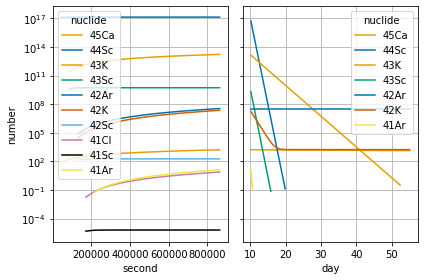

In [421]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"), x="second", y="number", hue="nuclide", ax=axs[0], palette=palette
)
sns.lineplot(
    df.query(f"time > {beam_time}"), x="day", y="number", hue="nuclide", ax=axs[1], palette=palette
)
axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

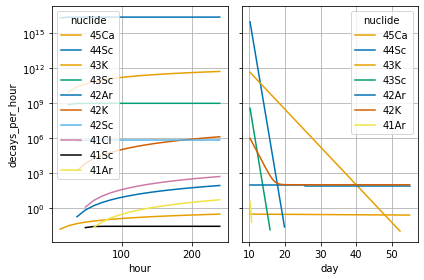

In [422]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"),
    x="hour",
    y="decays_per_hour",
    hue="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time}"),
    x="day",
    y="decays_per_hour",
    hue="nuclide",
    ax=axs[1],
    palette=palette,
)
axs[0].set_yscale("log")
axs[0].grid()
axs[1].grid()
plt.tight_layout()

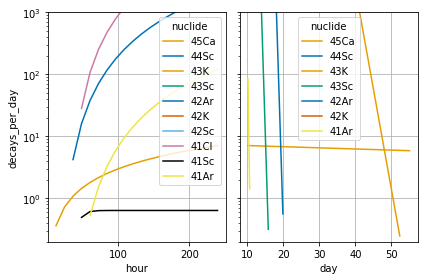

In [423]:
fig, axs = plt.subplots(1, 2, sharey=True)
sns.lineplot(
    df.query(f"time <= {beam_time}"),
    x="hour",
    y="decays_per_day",
    hue="nuclide",
    ax=axs[0],
    palette=palette,
)
sns.lineplot(
    df.query(f"time > {beam_time}"),
    x="day",
    y="decays_per_day",
    hue="nuclide",
    ax=axs[1],
    palette=palette,
)

axs[0].set_yscale("log")
axs[0].set_ylim(top=1e3, bottom=2e-1)
axs[0].grid()
axs[1].grid()
plt.tight_layout()

In [424]:
get_decay_rates("42Ar")

{'42K': 6.676285065740486e-19}